# Time Series Proof of of Concept
This blueprint demonstrates a full proof of concept for creating a synthetic financial time-series dataset and evaluating its privacy and accuracy for a predictive task


In [ ]:
%%capture

!pip install -U gretel-client
!pip install numpy pandas statsmodels matplotlib seaborn
!pip install -U scikit-learn


In [ ]:
import pandas as pd
import numpy as np
import statsmodels as sm
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import time

from typing import List, Dict
from getpass import getpass
from gretel_client import configure_session, ClientConfig


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Specify your Gretel API key

pd.set_option('max_colwidth', None)

configure_session(ClientConfig(api_key=getpass(prompt="Enter Gretel API key"), 
                               endpoint="https://api.gretel.cloud"))

Enter Gretel API key··········


In [ ]:
# Load timeseries example to a dataframe

data_source = 'https://gretel-public-website.s3.amazonaws.com/datasets/credit-timeseries-dataset.csv'
original_df = pd.read_csv(data_source)
original_df

,net_amt,date,account_balance,credit_amt,district_id,debit_amt
0,50425.0,1995-04-30,485849.7,232833.8,77,182408.8
1,22260.4,1995-03-31,435424.7,269788.6,77,247528.2
2,94953.0,1995-02-28,413164.3,272404.2,77,177451.2
3,13419.3,1994-11-30,476239.2,209552.5,77,196133.2
4,-109497.2,1995-01-31,318211.3,209838.0,77,319335.2
...,...,...,...,...,...,...
5539,320044.0,1996-02-29,997363.3,659139.6,4,339095.6
5540,80647.8,1995-12-31,836115.8,434639.6,4,353991.8
5541,-158796.5,1996-01-31,677319.3,408007.3,4,566803.8
5542,44954.8,1996-03-31,1042318.1,453294.0,4,408339.2


In [ ]:
# Gretel Transforms Configuration
config = """
schema_version: "1.0"
models:
    - transforms:
        data_source: "__tmp__"
        policies:
            - name: shiftnumbers
              rules:
                - name: shiftnumbers
                  conditions:
                    field_name:
                        - account_balance
                        - credit_amt
                        - debit_amt
                        - net_amt
                  transforms:
                    - type: numbershift
                      attrs:
                        min: 1
                        max: 100
                        field_name:
                            - date
                            - district_id
"""


In [ ]:
# De-identify the original dataset using the policy above
import yaml

from gretel_client import create_project
from gretel_client.helpers import poll

# Create a project and model configuration.
project = create_project(display_name="numbershift-transform")

model = project.create_model_obj(model_config=yaml.safe_load(config), data_source=data_source)

# Upload the training data.  Train the model.
model.submit_cloud()
poll(model)

record_handler = model.create_record_handler_obj(data_source=data_source)
record_handler.submit_cloud()
poll(record_handler)

deid_df = pd.read_csv(record_handler.get_artifact_link("data"), compression='gzip')

INFO: Starting poller


{
    "uid": "618ece1e76ada5c492b2a00a",
    "model_name": "cuddly-exuberant-giraffe",
    "runner_mode": "cloud",
    "user_id": "5f3c3afbbff62139634c66ca",
    "project_id": "618ece13fb70a590f651221e",
    "status_history": {
        "created": "2021-11-12T20:27:10.624354Z"
    },
    "last_modified": "2021-11-12T20:27:10.845018Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/transforms@sha256:1c84b3f2b15b8b3e19bd12f84c878b15b9bedd0b161d513236533f9c20d9b4d2",
    "model_type": "transform",
    "config": {
        "schema_version": "1.0",
        "name": null,
        "models": [
            {
                "transforms": {
                    "data_source": [
                        "gretel_62a2e31a554c45aba7cc9a57e13cf740_credit-timeseries-dataset.csv"
                    ],
                    "polic

INFO: Status is created. Model creation has been queued.
INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!
2021-11-12T20:27:24.690523Z  Starting transforms model training
2021-11-12T20:27:24.691297Z  Loading training data
2021-11-12T20:27:24.967552Z  Using up to 10000 records for training
2021-11-12T20:27:24.967982Z  Training data loaded
2021-11-12T20:27:24.968405Z  Beginning transforms model training
2021-11-12T20:27:53.396831Z  Saving model archive
2021-11-12T20:27:53.400203Z  Saving training report
2021-11-12T20:27:53.402669Z  Generating data preview with up to 100 records
2021-11-12T20:27:53.550505Z  Done generating data preview
2021-11-12T20:27:53.551373Z  Uploading artifacts to Gretel Cloud
2021-11-12T20:27:54.064294Z  Model creation complete!
INFO: Starting poller


{
    "uid": "618ece54b2e1d6e7276cc154",
    "model_name": null,
    "runner_mode": "cloud",
    "user_id": "5f3c3afbbff62139634c66ca",
    "project_id": "618ece13fb70a590f651221e",
    "status_history": {
        "created": "2021-11-12T20:28:04.770000Z"
    },
    "last_modified": "2021-11-12T20:28:04.855000Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/transforms@sha256:1c84b3f2b15b8b3e19bd12f84c878b15b9bedd0b161d513236533f9c20d9b4d2",
    "model_id": "618ece1e76ada5c492b2a00a",
    "action": "transform",
    "config": {
        "data_source": "gretel_8bdb1a97381e497eadd824cea60d0f78_credit-timeseries-dataset.csv",
        "params": null
    }
}


INFO: Status is created. A Record transform job has been queued.
INFO: Status is pending. A Gretel Cloud worker is being allocated to begin transforming records.
INFO: Status is active. A worker has started!
2021-11-12T20:28:14.585048Z  Downloading model to worker
2021-11-12T20:28:14.871498Z  Loading model
2021-11-12T20:28:14.964789Z  Loading dataset to transform
2021-11-12T20:28:15.106003Z  Starting transform
2021-11-12T20:28:17.772814Z  Transform in progress
{
    "records_transformed": 5544,
    "new_records_transformed": 5544
}
2021-11-12T20:28:17.773359Z  Dataset transform complete
2021-11-12T20:28:17.907613Z  Uploading data to Gretel Cloud
2021-11-12T20:28:18.242571Z  Uploading run report to Gretel Cloud


In [ ]:
# View the transformation report

import json
from smart_open import open

report = json.loads(open(model.get_artifact_link("report_json")).read())
pd.DataFrame(report["metadata"]["fields"])

,name,count,approx_distinct_count,missing_count,labels,attributes,entities,types
0,net_amt,5544,5453,0,[],[],[],"[{'type': 'number', 'count': 5544}]"
1,date,5544,72,0,[datetime],[],"[{'label': 'datetime', 'count': 5544, 'approx_distinct_count': 72, 'f_ratio': 1.0, 'sources': ['gretel/datetime']}]","[{'type': 'string', 'count': 5544}]"
2,account_balance,5544,5465,0,[],[],[],"[{'type': 'number', 'count': 5544}]"
3,credit_amt,5544,5466,0,[],[],[],"[{'type': 'number', 'count': 5544}]"
4,district_id,5544,77,0,[],[],"[{'label': 'location', 'count': 4896, 'approx_distinct_count': 68, 'f_ratio': 0.8831168831168831, 'sources': ['gretel/location']}]","[{'type': 'number', 'count': 5544}]"
5,debit_amt,5544,5319,0,[],[],[],"[{'type': 'number', 'count': 5544}]"


In [ ]:
# Here we sort and remove "net_amt" as it's a derived column, 
# We will add back in after the data is synthesized
train_df = deid_df.copy()

train_df.sort_values('date', inplace=True)
train_cols = list(train_df.columns)
train_cols.remove("net_amt")
train_df = train_df.filter(train_cols)

# Here we noticed that some number have extremely long precision, 
# so we round the data
train_df = train_df.round(1)
train_df.to_csv('train.csv', index=False)
train_df

,date,account_balance,credit_amt,district_id,debit_amt
1814,1993-01-31,1105.0,1183.0,52,92.0
5392,1993-01-31,82.0,1.0,2,79.0
3888,1993-01-31,252.0,290.0,23,84.0
1509,1993-01-31,12.0,94.0,56,30.0
1106,1993-01-31,6044.5,5986.5,62,10.0
...,...,...,...,...,...
5086,1998-12-31,2044873.7,827621.8,3,692404.7
169,1998-12-31,5873260.7,3070527.4,74,2491710.5
3228,1998-12-31,1599199.1,525952.4,30,462211.0
4743,1998-12-31,2266210.9,1086867.0,9,1010646.2


In [ ]:
from smart_open import open
import yaml

from gretel_client import create_project
from gretel_client.helpers import poll

# Create a project and model configuration.
project = create_project(display_name="ts-5544-regular-seed")

# Pull down the default synthetic config.  We will modify it slightly.
with open("https://raw.githubusercontent.com/gretelai/gretel-blueprints/main/config_templates/gretel/synthetics/default.yml", 'r') as stream:
    config = yaml.safe_load(stream)

#Set up the seed fields
seed_fields = ["date", "district_id"]

task = {
    'type': 'seed',
    'attrs': {
        'fields': seed_fields,
    }
}

# Fine tune model parameters. These are the parameters we found to work best.  This is "Run 20" in the document
config['models'][0]['synthetics']['task'] = task

config['models'][0]['synthetics']['params']['vocab_size'] = 19
config['models'][0]['synthetics']['params']['learning_rate'] = 0.001
config['models'][0]['synthetics']['params']['epochs'] = 500
config['models'][0]['synthetics']['params']['dropout_rate'] = .5
config['models'][0]['synthetics']['params']['gen_temp'] = .8
config['models'][0]['synthetics']['generate']['num_records'] = train_df.shape[0]

# Initiate a new model with the chosen config
model = project.create_model_obj(model_config=config)

# Get a csv to work with, just dump out the train_df.
deid_df.to_csv('train.csv', index=False)
model.data_source = 'train.csv'

# Upload the training data.  Train the model.
model.submit(upload_data_source=True)
poll(model)

synthetic = pd.read_csv(model.get_artifact_link("data_preview"), compression='gzip')
synthetic

INFO: Starting poller


{
    "uid": "618ecf765e69e25e362402eb",
    "model_name": "beautiful-clever-mule",
    "runner_mode": "cloud",
    "user_id": "5f3c3afbbff62139634c66ca",
    "project_id": "618ecf6f6eed9f83fe16e913",
    "status_history": {
        "created": "2021-11-12T20:32:54.143322Z"
    },
    "last_modified": "2021-11-12T20:32:54.392909Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/synthetics@sha256:2047340099facbfec3ba1d75e92881c83decd03d831c55fa23340afb40520a4d",
    "model_type": "synthetics",
    "config": {
        "schema_version": "1.0",
        "name": null,
        "models": [
            {
                "synthetics": {
                    "params": {
                        "field_delimiter": null,
                        "epochs": 500,
                        "batch_size": 64,
                      

INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!
2021-11-12T20:33:04.475187Z  Starting synthetic model training
2021-11-12T20:33:04.477224Z  Loading training data
2021-11-12T20:33:04.676914Z  Training data loaded
{
    "record_count": 5544,
    "field_count": 6
}
2021-11-12T20:33:06.673785Z  Creating semantic validators and preparing training data
2021-11-12T20:33:08.496953Z  Beginning ML model training
2021-11-12T20:33:21.634633Z  Training epoch completed
{
    "epoch": 0,
    "accuracy": 0.2517,
    "loss": 2.4227,
    "val_accuracy": 0,
    "val_loss": 0,
    "batch": 0
}
2021-11-12T20:33:23.269535Z  Training epoch completed
{
    "epoch": 1,
    "accuracy": 0.3591,
    "loss": 1.9895,
    "val_accuracy": 0,
    "val_loss": 0,
    "batch": 0
}
2021-11-12T20:33:24.901158Z  Training epoch completed
{
    "epoch": 2,
    "accuracy": 0.4402,
    "loss": 1.6748,
    "val_accuracy":

,net_amt,date,account_balance,credit_amt,district_id,debit_amt
0,36245.0,1995-04-30,479075.8,184270.5,77,149976.8
1,-26014.0,1995-03-31,513442.6,200522.1,77,212837.9
2,356644.5,1995-02-28,303380.7,216356.9,77,153479.2
3,38186.2,1994-11-30,903150.2,511900.6,77,510273.8
4,-107506.1,1995-01-31,453591.1,306842.4,77,415988.6
...,...,...,...,...,...,...
5539,-302134.6,1997-12-31,1589662.4,932744.6,1,1138694.8
5540,-136730.0,1995-12-31,637886.2,472857.0,1,517900.0
5541,956905.3,1997-07-31,2213723.5,1660758.9,1,1219091.8
5542,-423643.3,1996-10-31,1595499.3,1013160.5,1,934854.7


In [ ]:
# Add back in the derived column "net_amt"
net_amt = synthetic["credit_amt"] - synthetic["debit_amt"]
synthetic["net_amt"] = net_amt

# Save off the new synthetic data
synthetic.to_csv("synthetic.csv", index=False, header=True)

In [ ]:
# View the Synthetic Performance Report
import IPython
from smart_open import open

IPython.display.HTML(data=open(model.get_artifact_link("report")).read())

<Figure size 432x288 with 0 Axes>

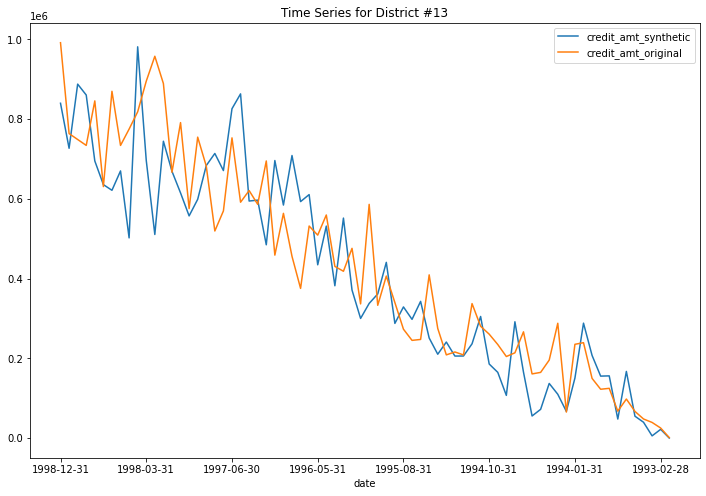

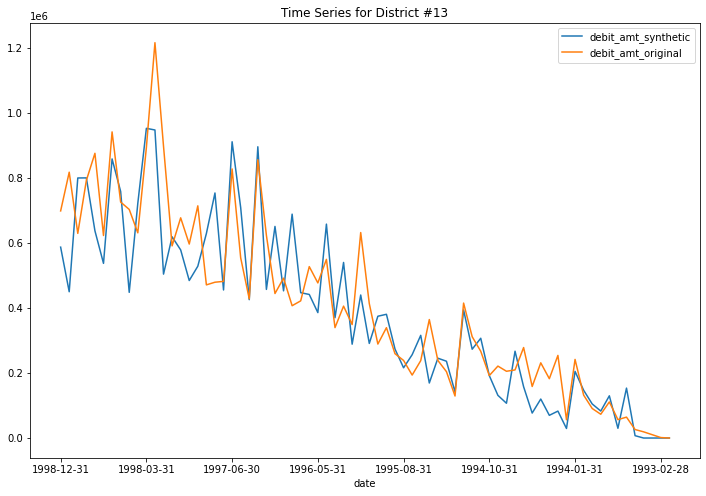

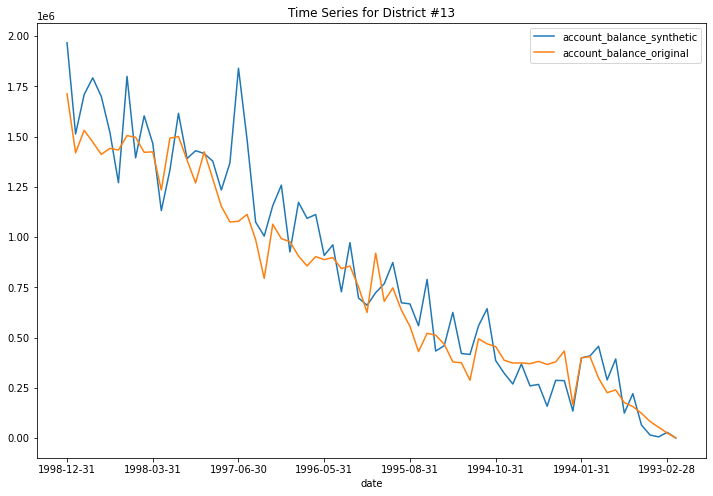

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
        
def plot_district_averages(synthetic: pd.DataFrame, training: pd.DataFrame, district_id: int) -> pd.DataFrame:

    synthetic_data = synthetic.loc[synthetic['district_id']==district_id]
    synthetic_data = synthetic_data.set_index('date')

    training_data = training.loc[training['district_id']==district_id]
    training_data = training_data.set_index('date')
    
    combined = synthetic_data.join(training_data, lsuffix='_synthetic', rsuffix='_original')
    plt.suptitle('District #'+str(district_id))

    for col in ['credit_amt', 'debit_amt', 'account_balance']:
        fig = combined.plot(y=[f'{col}_synthetic', f'{col}_original'], figsize=(12, 8))
        plt.title('Time Series for District #'+str(district_id))

    return combined
        
combined = plot_district_averages(synthetic, train_df, 13)

In [ ]:
import warnings

warnings.filterwarnings('ignore')

def ARIMA_run(data_paths: List[str], 
              targets: List[str] = None, 
              entity_column: str = 'district_id', 
              entities: List = None, 
              date_column: str = 'date', 
              date_threshold: str = None) -> Dict[str, List[float]]:
  '''
  Purpose of this function is to automate the run and scoring of SARIMAX models, so we can benchmark results against various different synthetic data configurations.
  The data paths from s3 are passed in, and then entire run, from loading in and sorting the data to creating a model and scoring it, is done via this function.
  The outputs are the target scores for each variable on each dataset's model. This gets used to create bar charts of the RMSE.
  With some fine tuning, this function can be made as a general purpose SARIMAX benchmark function for a variety of datasets.

  Args:
    data_paths: a list of paths to the data you want to create models and score with. These can be either local paths or ones from public buckets.
    targets: Which columns in the data will be your target variables?
    entity_column: This is purely used for datasets that have multiple time series data points from multiple places. Since this function was built with that in mind, it assumes that you will
    give a column that denotes those different places/entities. If None is provided, no handler has been built yet that can handle that.
    entities: This should be a list of the set of entities within the entity column.
    date_column: This should be something we can use to sort the data, so that the time series is read appropriately.
    date_threshold: This is to split the data into train and test. Whatever date you want to threshold by to make the train and test should be specified here.

  Outputs:
    target_scores: This will be a dictionary of RMSE scores for each target variable on each synthetic dataset.
  '''
  target_scores = {}
  for target in targets:
    target_scores[target] = []
  for path in data_paths:
    sorted_data = pd.read_csv(path)
    sorted_data.sort_values(date_column, inplace=True)
    sorted_data.drop_duplicates(subset = [date_column, entity_column], inplace = True)

    print('Path: {}'.format(path))
    for entity in entities:
      print('Entity: {}'.format(entity))
      for target in targets:
        train_data = sorted_data[sorted_data[entity_column] == entity][sorted_data[date_column] < date_threshold]
        test_data = sorted_data[sorted_data[entity_column] == entity][sorted_data[date_column] >= date_threshold]

        model = sarimax.SARIMAX(train_data[target], order=(0,1,1), seasonal_order=(1,1,0,12))
        res = model.fit()

        preds = res.forecast(len(test_data[target]))
        rmse = mean_squared_error(test_data[target], preds, squared = False)
        target_scores[target].append(rmse)
        print('Target: {}'.format(target))
        print('RMSE: {}'.format(rmse))

  return target_scores


In [ ]:
target_scores = ARIMA_run(['synthetic.csv', 'original.csv'], targets = ['net_amt', 'account_balance', 'credit_amt', 'debit_amt'], entities = [13], date_threshold = '1998-01-01')

Path: synthetic.csv
Entity: 13
Target: net_amt
RMSE: 165892.1607782128
Target: account_balance
RMSE: 323847.1775082712
Target: credit_amt
RMSE: 218625.83320380733
Target: debit_amt
RMSE: 200678.95502342907
Path: original.csv
Entity: 13
Target: net_amt
RMSE: 108404.54757804466
Target: account_balance
RMSE: 174944.60345974631
Target: credit_amt
RMSE: 131771.15678002918
Target: debit_amt
RMSE: 151182.29274964918


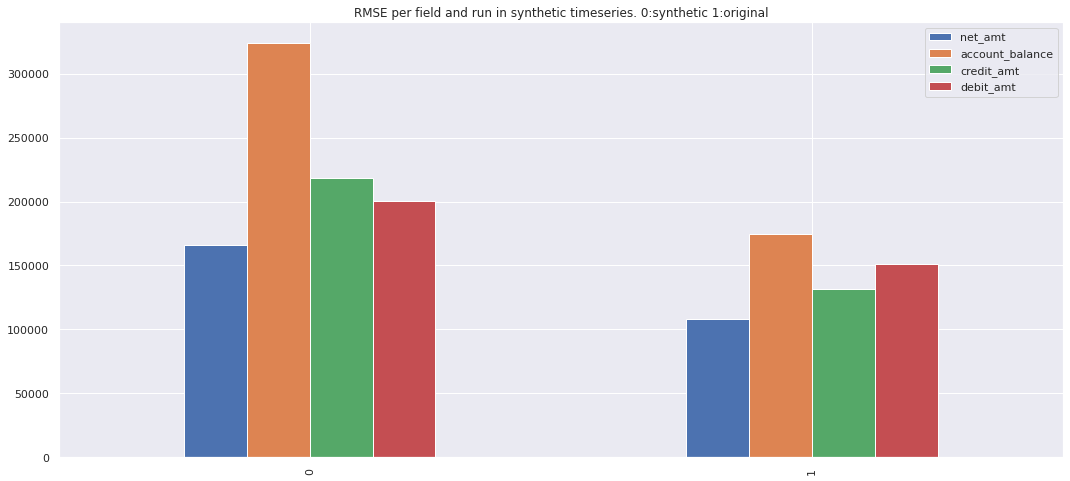

In [ ]:
pd.DataFrame(target_scores).plot.bar(title="RMSE per field and run in synthetic timeseries. 0:synthetic 1:original")